### Prepare Data

In [ ]:
from glob import glob
from ConceptMining import ConceptMiner
from settings import settings

import pickle

In [ ]:
batch_size = 70
images = [i for i in glob("../dataset/Images/*.jpg")]
Miner = ConceptMiner(images = images, load_model= True)

# encodings, captions = Miner.get_image_caption(get_encodings = True, batch_size = batch_size)

In [ ]:
# with open('encodings.pkl', 'wb') as f:
#     pickle.dump({'encodings':encodings, 'captions': captions}, f)
with open('encodings.pkl', 'rb') as f:
	data = pickle.load(f)
	encodings = data['encodings']
	captions = data['captions']

In [ ]:
concept_model, generated_concepts = Miner.concept_modeling(encodings = encodings, 
                                                           captions = captions, 
                                                           batch_size = batch_size)

with open("generated_concepts.pkl", "wb") as f:
    pickle.dump(generated_concepts, f)


### Cluser topics by semantic similarity 
- Cluser concepts
- Sample concepts taking as mean the centroid +- a random noice to simulate user externalization

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from umap import UMAP
import os, pickle
import numpy as np

from transformers import AutoTokenizer, AutoModel

with open("generated_concepts.pkl", "rb") as f:
    generated_concepts = list(set(pickle.load(f)) - {""})
    
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embedding(sentences, model, tokenizer, batch_size = 16):
    with torch.no_grad():

        output = None
        for i in range(0, len(sentences), batch_size):
            encoded_input = tokenizer(sentences[i: i + batch_size], padding=True, return_tensors='pt')

            model_output = model(**encoded_input)
            sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            output = sentence_embeddings if output is None else torch.cat([output, sentence_embeddings])

    return output

concepts_embeddings = get_embedding(generated_concepts, model, tokenizer, batch_size = 16)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

similarity_matrix = cosine_similarity(concepts_embeddings)

# Apply Spectral Clustering
num_clusters = 20
spectral = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
labels = spectral.fit_predict(similarity_matrix)

# Group words by topic
topic_groups = {}
for word, cluster in zip(generated_concepts, labels):
    topic_groups.setdefault(cluster, []).append(word)
    
with open("generated_concepts.pkl", "wb") as f:
	pickle.dump({'concepts':generated_concepts,
              'topic_groups': topic_groups}, f)

#### Preprocess the data for simulation


In [ ]:
import pickle
from glob import glob

import random

with open("generated_concepts.pkl", "rb") as f:
	data = pickle.load(f)
	generated_concepts = data['concepts']
	topic_groups = data['topic_groups']

with open('encodings.pkl', 'rb') as f:
	data = pickle.load(f)
	encodings = data['encodings']
	captions = data['captions']

images = [i for i in glob("../dataset/Images/*.jpg")]

##### Encode all text and images to speed up training


In [ ]:
from PIL import Image
import pickle
from tqdm import tqdm

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

batch_size = 70
# encode all images using output of a single text
image_encodings = []

for batch in tqdm(range(0, len(images), batch_size)):
	image = [Image.open(i) for i in images[batch: batch + batch_size]]
	inputs = processor(text=["a photo of a cat"] * len(image), images=image, return_tensors="pt", padding=True).to("cuda")
	outputs = model(**inputs, return_dict = True)
	image_encodings += [outputs.image_embeds.cpu().detach()]

image_encodings = torch.cat(image_encodings)

# encode all concepts using output of a single image
concept_encodings = []
for batch in tqdm(range(0, len(generated_concepts), batch_size)):
	concepts = generated_concepts[batch: batch + batch_size]
	inputs = processor(text=concepts, images=[Image.open(images[0])], return_tensors="pt", padding=True).to("cuda")
	outputs = model(**inputs, return_dict = True)
	concept_encodings += [outputs.text_embeds.cpu().detach()]

concept_encodings = torch.cat(concept_encodings)
with open("clip_encodings.pkl", "wb") as f:
	pickle.dump({'image_encodings': image_encodings,
			  'concept_encodings': concept_encodings}, f)

In [ ]:
concept_instance = {i:[] for i in generated_concepts}

for i, path in enumerate(images):
	for c in captions[i].split():
		if c in generated_concepts:
			concept_instance[c] += [path]

remove_topics = []
for i in topic_groups:
	remove = [j for j in topic_groups[i] if len(concept_instance[j]) < 10]
	for j in remove:
		topic_groups[i].remove(j)
	print(f"Topic {i}:", len(topic_groups[i]))
	if len(topic_groups[i]) < 8:
		remove_topics.append(i)

for i in remove_topics:
	del topic_groups[i]

In [ ]:
from matplotlib import pyplot as plt	
plt.bar(range(len(generated_concepts)), sorted([len(i) for i in concept_instance.values()]), log = True)
plt.title("Concepts Frequency")
plt.xlabel("Concepts")

In [ ]:
plt.bar(range(len(topic_groups)), [len(topic_groups[i]) for i in topic_groups], color = 'r')
plt.title("Topics Size")
plt.xlabel("Topics")

In [ ]:
import gymnasium as gym
from matplotlib import pyplot as plt

# from Actor_Critic import AdaptationEngine
from ContextualBandit import AdaptationEngine
from tqdm import tqdm
import torch

import random; random.seed(42)


def encode_actions(action, n_actions):

	if not isinstance(action, torch.Tensor):
		action = torch.tensor(action)
	return torch.nn.functional.one_hot(action, num_classes=n_actions).float()

def preprocess_state(state):
	return torch.tensor(state).float().reshape(1, -1)

def get_entropy(preferences):
	return -torch.sum(preferences * torch.log(preferences), dim = -1)

episodes = 0
episode_length = 1000
dataset_coverage_step = .75
gamma = 0.99
buffer = []
actions_embedd_dim = 2
buffer_size = 245

lr_actor = 0.01
lr_critic = 0.0001

temperature = .2
final_temperature = 0.1
decay_rate = 0.999  # Decay per episode


# env = gym.make('MountainCar-v0')
env = gym.make('CartPole-v1')

# Pi = Actor(state_dim = env.observation_space.shape[0], action_dim = actions_embedd_dim, lr_optimizer = lr_actor)
# V = Critic(state_dim = env.observation_space.shape[0], lr_optimizer = lr_critic)
Agent = AdaptationEngine(state_dim = env.observation_space.shape[0],
						 action_space_len=env.action_space.n,
						 	action_dim=env.action_space.n,
							lr_actor = lr_actor,
							lr_critic = lr_critic,
							gamma = gamma,
							buffer_size = buffer_size,
							sample_temperature = temperature,
							final_temperature = final_temperature,
							temperatura_decay = decay_rate)

actions_encode = encode_actions([i  for i in range(env.action_space.n)], env.action_space.n).to(Agent.device)

episode_history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}

history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}


for episode in range(episodes):

	prev_state, _ = env.reset()
	prev_state = preprocess_state(prev_state)

	episode_history = {'rewards': [],
		'loss_critic': [], 
		'loss_actor': [],
		'entropy': []}
			
	itera = tqdm(range(episode_length))
	itera.set_description(f"Episode {episode}")

	for step in itera:
		with torch.no_grad():
			Agent.eval()
			preferences = Agent.policy(prev_state, actions_encode)	
			# print(preferences)
			
			if random.random() < Agent.temperature:
				action = torch.randint(0, env.action_space.n, (1,)).item()
			else:
				action = torch.argmax(preferences).item()
			
			state, reward, done, truncated, _ = env.step(action)
			state = preprocess_state(state)
		Agent.train()

		Agent.push_buffer(state=prev_state,
					 action=torch.tensor(action), 
					 reward=reward, 
					 next_state=state, 
					 done=done)
		
		episode_history['rewards'].append(reward)
		# episode_history['entropy'].append(get_entropy(preferences).mean().item())

		if Agent.buffer_size <= len(Agent.buffer):
			actor_loss = Agent.optimization_step(actions_encode)
			# actor_loss, critic_loss = Agent.optimization_step(actions_encode)
			# episode_history['loss_critic'].append(critic_loss)
			episode_history['loss_actor'].append(actor_loss)

		prev_state = state

		itera.set_postfix({'Temperature': f'{temperature:.4f}',
						'Reward': sum(episode_history['rewards']),
						# 'entropy': sum(episode_history['entropy']),
						# 'Loss Critic': sum(episode_history['loss_critic']),
						'Loss Actor': sum(episode_history['loss_actor'])} )
		if done or truncated:
			history['rewards'].append(sum(episode_history['rewards']))
			# history['loss_critic'].append(sum(episode_history['loss_critic']))
			history['loss_actor'].append(sum(episode_history['loss_actor']))
			break

	temperature = max(final_temperature, temperature * decay_rate)
	if Agent.max_reward is None or Agent.max_reward < sum(episode_history['rewards']):
		Agent.max_reward = sum(episode_history['rewards'])
		Agent.Actor.save(f"bandit.pt")

env.close()

In [ ]:
Agent.eval()
print(Agent.policy(prev_state, actions_encode))
prev_state	

In [ ]:
plt.plot(history['rewards'])
plt.title("Rewards")
plt.xlabel("Iterations")

In [ ]:
import gymnasium as gym
from matplotlib import pyplot as plt

# from Actor_Critic import AdaptationEngine
from ContextualBandit import AdaptationEngine
from tqdm import tqdm
import torch

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def show_state(env, step=0):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title(f"Step: {step}")
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


env = gym.make('CartPole-v1', render_mode='rgb_array')
Agent = AdaptationEngine(state_dim = env.observation_space.shape[0],
						 action_space_len=env.action_space.n,
							action_dim=env.action_space.n)

# Agent = AdaptationEngine(state_dim = env.observation_space.shape[0],
						 
# 						 	action_dim=env.action_space.n,
# 							lr_actor = lr_actor,
# 							lr_critic = lr_critic,
# 							gamma = gamma,
# 							buffer_size = buffer_size,
# 							sample_temperature = temperature,
# 							final_temperature = final_temperature,
# 							temperatura_decay = decay_rate)
                            
Agent.Actor.load('bandit.pt')
Agent.eval()
# env = gym.make('MountainCar-v0', render_mode='rgb_array')

prev_state, info = env.reset()
prev_state = preprocess_state(prev_state)
print(prev_state)
for step in range(int(100)):
	preferences =  Agent.policy(prev_state, actions_encode)

	action = preferences.argmax()

	observation, reward, terminated, _, _ = env.step(action.item())
	print(action)

	prev_state = preprocess_state(observation)
	prev_action = action

	show_state(env, step=step)

	if terminated:
		print(observation)
		break

env.close()


### Exploration Agent

#### Optuna for settings (hyperparameters - actor critic)

In [ ]:
import random; random.seed(0)
import numpy as np; np.random.seed(0)

from utils import train_agent

settings = {'episode_length': 1000,
            'episodes': 3000,
            'gamma': 0.99,
            'decay_rate': 0.95,
            'buffer_size': 256,
            'lr_critic': 5e-4, #3e-4 #0.002159000868210698,
            'lr_actor': 3e-4, #1e-4#0.0007674507120792033,
            'temperature': 5,
			'final_temperature': 1}
    

average_reward, deviation_reward, history = train_agent(settings, use_mlflow = False, save_suffix = "_best")

### Simualte Exploration

In [ ]:
import pickle
from matplotlib import pyplot as plt
from glob import glob

from Concept_Mining.SimulationEnvironment import explore_environment
from Actor_Critic import AdaptationEngine
from settings import  pretraining_settings as settings
from tqdm import tqdm
import torch
import numpy as np

def get_entropy(preferences):
	return -torch.sum(preferences * torch.log(preferences), dim = -1)

with open("clip_encodings.pkl", "rb") as f:
	data = pickle.load(f)
	image_encodings = data['image_encodings']
	actions_encode = data['concept_encodings']

with open("generated_concepts.pkl", "rb") as f:
	data = pickle.load(f)
	generated_concepts = data['concepts']
	topic_groups = data['topic_groups']

with open('encodings.pkl', 'rb') as f:
	captions = pickle.load(f)['captions']

images = [i for i in glob("../dataset/Images/*.jpg")]

Agent = AdaptationEngine(state_dim = image_encodings.shape[1] + actions_encode.shape[1],
						 	action_dim=actions_encode.shape[1],
							action_space_len=actions_encode.shape[0],
							lr_actor = settings.lr_actor,
							lr_critic = settings.lr_critic,
							gamma = settings.gamma,
							buffer_size = settings.buffer_size,
							sample_temperature = settings.temperature,
							final_temperature = settings.final_temperature,
							temperature_decay = settings.decay_rate)

def get_trajectory( env_snapshot, state, trajectory_len: int = 10 ):
	
	current_path = []
	processed_state = env_snapshot.preprocess_state(state)

	for _ in range(trajectory_len):
		
		preferences = Agent.policy(processed_state, actions_encode)
		action = preferences.argmax() #torch.multinomial(preferences, 1).squeeze(-1)
		
		current_path.append(action.item())
		processed_state = env_snapshot.preprocess_state(state, current_path=current_path)
	
	return current_path

env = explore_environment(topic_groups=topic_groups, 
						  concepts=generated_concepts,
						  concepts_encode=actions_encode,
						  images=images,
						  images_caption=captions,
						  images_encode=image_encodings, 
						  threshold=10)


Agent.Actor.load('actor_9.pt')
Agent.eval()
# Agent.Critic.load('critic_best.pt')
prediction = []
remaining = []

taken_actions = []

with torch.no_grad():
	for episode in range(1):

		episode_index, (prev_state, feedback, _) = env.reset()
		prev_state = env.preprocess_state(prev_state)

		env.externalized.add(feedback)
				
		itera = tqdm(range(len(env.topic)))
		itera.set_description(f"Episode {episode}")

		for step in itera:

			# actions_trajectory = get_trajectory(env, prev_state, trajectory_len = 10)

			# prediction.append(actions_trajectory.copy())
			# remaining.append(env.topic[env.step_index:].copy())
			preferences = Agent.policy(prev_state, actions_encode)
			action = torch.multinomial(preferences, 1).squeeze(-1)

			state, feedback, _, done = env.step( action.item() )
			taken_actions.append(action.item())
			print(action.item(), generated_concepts[action.item()])
			state = env.preprocess_state(state)
			# state, feedback, _, done = env.step( actions_trajectory[0] )
			env.externalized.add(feedback)
			# actions_trajectory = state
			prev_state = state

			if done:
				break		

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE

np.random.seed(42)
embeddings_1 = actions_encode[env.topic]

embeddings_2 = actions_encode[taken_actions] 
Set1 = ["Externalized"]*len(embeddings_1) 
Set2 = ["Proposed"]*len(embeddings_2)  # Labels for second set

labels_1 = [generated_concepts[i] for i in env.topic] 
labels_2 = [generated_concepts[i] for i in taken_actions] # Labels for second set

# Concatenate embeddings
embeddings = np.vstack([embeddings_1, embeddings_2])
labels = labels_1 + labels_2  # Merge labels
Sets = Set1 + Set2

# Dimensionality Reduction (Use TSNE or UMAP)
reducer = TSNE(n_components=2, perplexity=5, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)

# Create DataFrame
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["Set"] = Sets  # Assign label to distinguish sets
df["Label"] = labels  # Assign label for hover


# Custom color mapping (Red for Set 1, Blue for Set 2)
color_map = {"Set 1": "red", "Set 2": "blue"}

# Interactive Plot
fig = px.scatter(df, x="x", y="y", color="Set", hover_data=["Label"], title="Comparison of Two Embedding Sets",
                 color_discrete_map=color_map, size_max=30)
fig.show()

In [1]:
import pickle
from glob import glob
from SimulationEnvironment import explore_environment


with open("clip_encodings.pkl", "rb") as f:
	data = pickle.load(f)
	image_encodings = data['image_encodings']
	actions_encode = data['concept_encodings']

with open("generated_concepts.pkl", "rb") as f:
	data = pickle.load(f)
	generated_concepts = data['concepts']
	topic_groups = data['topic_groups']

with open('encodings.pkl', 'rb') as f:
	captions = pickle.load(f)['captions']

images = [i for i in glob("../dataset/Images/*.jpg")]

env = explore_environment(topic_groups=topic_groups, 
						concepts=generated_concepts,
						concepts_encode=actions_encode,
						images=images,
						images_caption=captions,
						images_encode=image_encodings, 
						threshold=10)

In [2]:
x = env.reset(1)
# episode_index, (prev_state, feedback, _) = env.reset()

## Greedy 

Episode 0:  93%|█████████▎| 26/28 [00:03<00:00,  8.10it/s]


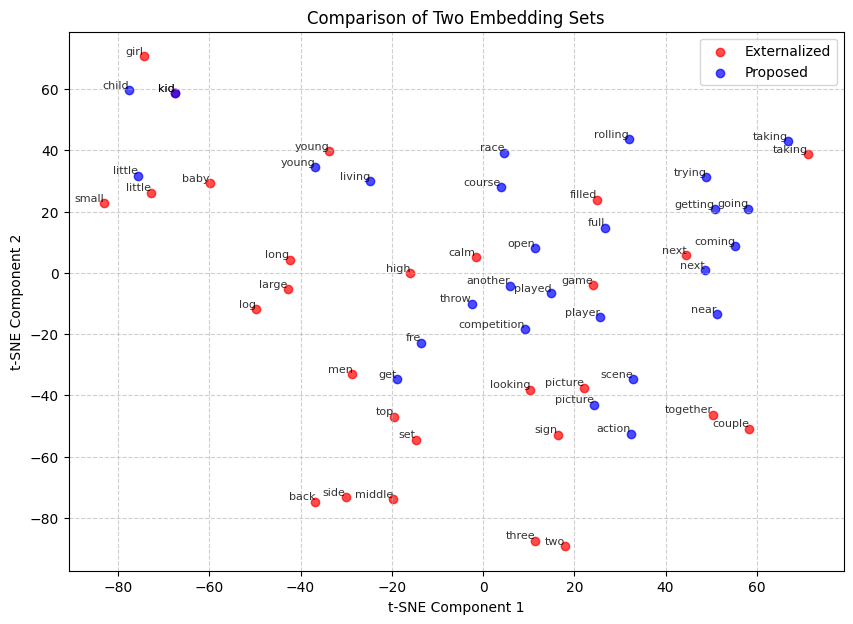

Ground Truth: filled,side,picture,men,large,girl,game,baby,calm,young,middle,next,high,back,small,looking,set,kid,two,taking,top,little,log,three,couple,together,sign,long

Proposed: full,picture,another,getting,get,action,going,scene,young,competition,next,race,coming,course,open,trying,kid,played,taking,near,little,player,throw,living,child,rolling,fre



In [5]:
import pickle
from matplotlib import pyplot as plt
from glob import glob
from sklearn.metrics.pairwise import cosine_similarity

from SimulationEnvironment import explore_environment
from utils_bandits import plot_exploration
from settings import  pretraining_settings as settings
from tqdm import tqdm
import torch
import numpy as np

with open("clip_encodings.pkl", "rb") as f:
	data = pickle.load(f)
	image_encodings = data['image_encodings']
	actions_encode = data['concept_encodings']

with open("generated_concepts.pkl", "rb") as f:
	data = pickle.load(f)
	generated_concepts = data['concepts']
	topic_groups = data['topic_groups']

with open('encodings.pkl', 'rb') as f:
	captions = pickle.load(f)['captions']

images = [i for i in glob("../dataset/Images/*.jpg")]

env_tmp = explore_environment(topic_groups=topic_groups, 
						concepts=generated_concepts,
						concepts_encode=actions_encode,
						images=images,
						images_caption=captions,
						images_encode=image_encodings, 
						threshold=10)

taken_actions = []

topic_index = 1
save_plot = False

def select_greedy_action(externalized, images, action_encode, taken_actions):
	
	context = action_encode[list(externalized | set(taken_actions))]
	images = images[:, :-action_encode.shape[1]]


	compatibility_text =  cosine_similarity(action_encode, context).mean(axis = -1)
	#mask compatibility of index already taken

	compatibility_image = cosine_similarity(action_encode, images).mean(axis = -1)
	compatibility = compatibility_text*0.5 + compatibility_image*0.5
	
	compatibility[list(externalized | set(taken_actions))] = -100

	#sample action using compatibiliy values as distribution
	action = torch.argmax(torch.tensor(compatibility)).item()
	return action

with torch.no_grad():
	for episode in range(1):

		episode_index, (prev_state, feedback, _) = env_tmp.reset(topic_index)
		prev_state, prev_action_seq = env_tmp.preprocess_state(prev_state)

		env_tmp.externalized.add(feedback)
		
		if not save_plot:
			itera = tqdm(range(len(env_tmp.topic)))
			itera.set_description(f"Episode {episode}")
		else:
			itera = range(len(env_tmp.topic))

		for step in itera:

			action = select_greedy_action(env_tmp.externalized, prev_state, actions_encode, taken_actions)

			state, feedback, _, done = env_tmp.step( action )
			taken_actions.append(action)
			# print(action.item(), generated_concepts[action.item()])
			state, action_seq = env_tmp.preprocess_state(state)
			# state, feedback, _, done = env.step( actions_trajectory[0] )
			env_tmp.externalized.add(feedback)
			# actions_trajectory = state
			prev_state = state
			prev_action_seq = action_seq

			if done:
				break		

plot_exploration(actions_encode = actions_encode, env = env_tmp, 
			taken_actions = taken_actions, generated_concepts = generated_concepts, 
			save_plot = save_plot, episode_index = topic_index,
			output_path = '.')

